## Removing Stray Magnetic Fields from the KPLO Magnetometer Measurements

In [1]:
"Import Necessary Libraries"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fcwt

## July 31st, 2023

In [2]:
"Load KMAG Data"
kmag = pd.read_csv(r'C:\Users\aphoffm2\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230731_000000_RAW_M_01_one_second_average.csv')
B = kmag[['MAG1X','MAG1Y', 'MAG1Z','MAG2X', 'MAG2Y','MAG2Z', 'MAG3X','MAG3Y', 'MAG3Z']].to_numpy().T
B = B.reshape(3, 3, B.shape[-1])
t = pd.to_datetime(kmag['UTC']).to_numpy()

In [3]:
"Interpolate Gaps"
from magprime.utility import interpolation
interpolation.mssa.n_components = "parallel_analysis"
interpolation.mssa.pa_percentile_threshold = 95
interpolation.mssa.verbose = False

gaps = 1- np.isnan(B[0,0])
B_interpolated_x = interpolation.mssa.interpolate(np.copy(B[:,0]), np.copy(gaps), triaxial=False)
B_interpolated_y = interpolation.mssa.interpolate(np.copy(B[:,1]), np.copy(gaps), triaxial=False)
B_interpolated_z = interpolation.mssa.interpolate(np.copy(B[:,2]), np.copy(gaps), triaxial=False)
B_interpolated = np.stack((B_interpolated_x, B_interpolated_y, B_interpolated_z), axis=1)

c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
100%|██████████| 4/4 [00:00<00:00, 1507.66it/s]


In [4]:
"Correct Low Frequency Offset"
from magprime.algorithms import RAMEN
from scipy.ndimage import uniform_filter1d
from importlib import reload
reload(RAMEN)

"Detrend"
sensors = np.copy(B_interpolated)
uf = 4*int(7200) # Two Hours
trend = uniform_filter1d(sensors, size=uf)
sensors = sensors - trend

"Apply RAMEN"
ramen_trend = RAMEN.clean(trend[:2]) # Only take trend from MAG-1 and MAG-2

"Plot Trend data"
plt.figure()
plt.plot(t, ramen_trend[0], label='X')
plt.plot(t, ramen_trend[1], label='Y')
plt.plot(t, ramen_trend[2], label='Z')
plt.legend()
plt.title('RAMEN Trend')
plt.show()


In [ ]:
"Apply WAIC-UP"
from magprime.algorithms import WAICUP


"Note: WAIC-UP is not designed to work with low-frequency data due to the Cone of Influence (COI). Detrending is necessary to avoid low-frequency artefacts."
WAICUP.fs = 1 # Sampling Frequency
WAICUP.detrend = False # Detrend the data

"Clean the data"
B_WAICUP = WAICUP.clean(np.copy(sensors), triaxial=True)


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\magprime\algorithms\WAICUP.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  waicup_level1[i] = dual(np.vstack((sig[pairs[i][0]], sig[pairs[i][1]])), dt, dj)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\magprime\algorithms\WAICUP.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  result[axis] = cleanWAICUP(B[:,axis,:])


In [ ]:
"Find Correlation of WAIC-UP"
from scipy.stats import pearsonr
B_noise = sensors[2]-sensors[0]

correlation = [pearsonr(B_noise[i], B_WAICUP[i])[0] for i in range(3)]
print(correlation)

correlation = [pearsonr(B_noise[i], sensors[0,i])[0] for i in range(3)]
print(correlation)


[-0.41682701872332883, 0.18814654487952942, -0.33793199000697893]
[-0.8444877744845715, 0.7091472871017654, -0.8563298317733211]


[0, 86400, 0, 300]


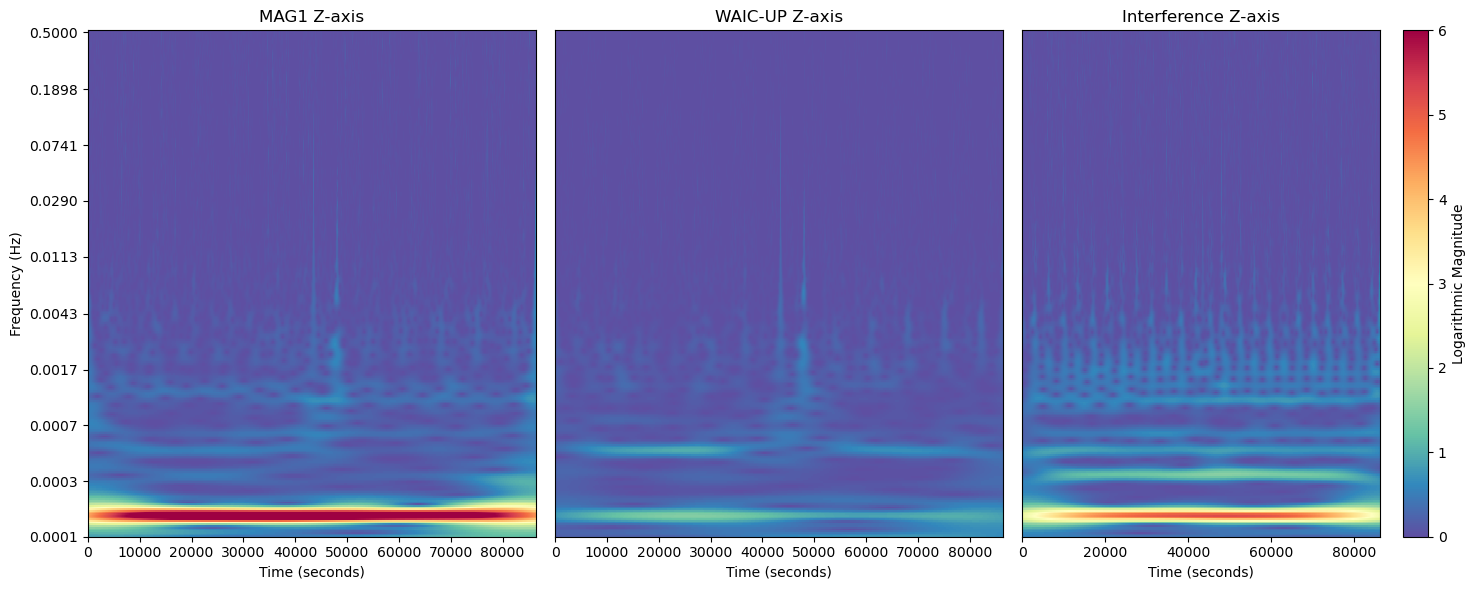

In [ ]:
"Take Continuous Wavelet Transform"
fs = 1  # Hz
f0 = 0.0001 # Hz
f1 = 0.5  # Hz

# take transform of B_kplo Z-axis
freqs, out_kplo = fcwt.cwt(sensors[0,2], fs, f0, f1, fn=300, scaling='log', nthreads=12)
freqs = np.flip(freqs)

# take transform of WAICUP Z-axis
_, out_waicup = fcwt.cwt(B_WAICUP[2], fs, f0, f1, fn=300, scaling='log', nthreads=12)

# take transform of Interference Z-axis
_, out_noise = fcwt.cwt(sensors[2,2] - sensors[0,2], fs, f0, f1, fn=300, scaling='log', nthreads=12)

# Plot CWT
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
extent_kplo = [0, out_kplo.shape[1], 0, out_kplo.shape[0]]
print(extent_kplo)
cax1 = axs[0].imshow(np.abs(out_kplo), aspect='auto', extent=extent_kplo, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=6)
cax2 = axs[1].imshow(np.abs(out_waicup), aspect='auto', extent=extent_kplo, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=6)
cax3 = axs[2].imshow(np.abs(out_noise), aspect='auto', extent=extent_kplo, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=6)
fig.colorbar(cax3, ax=axs[2], label='Logarithmic Magnitude')

yticks_kplo = np.linspace(0, len(freqs) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs[i]:.4f}" for i in yticks_kplo]

axs[0].set_yticks(yticks_kplo)
axs[0].set_yticklabels(yticklabels_kplo)
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title("MAG1 Z-axis")

# TURN OFF YTICKS FOR AXS[1] AND AXS[2]
axs[1].set_yticks([])
axs[1].set_xlabel('Time (seconds)')
axs[1].set_title("WAIC-UP Z-axis")

axs[2].set_yticks([])
axs[2].set_xlabel('Time (seconds)')
axs[2].set_title("Interference Z-axis")
plt.tight_layout()
plt.show()


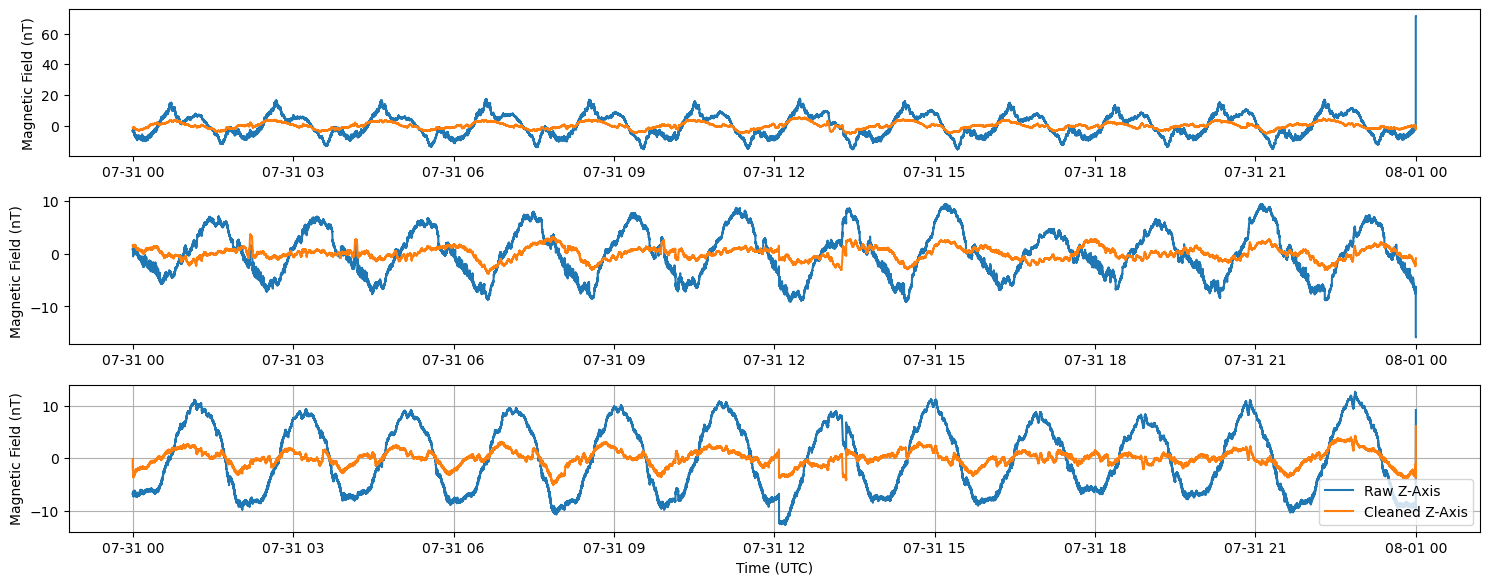

In [ ]:
# Plot time series of B_waicup in 3 panel plot
fig, axs = plt.subplots(3, 1, figsize=(15, 6))
axs[0].plot(t, sensors[0,0], label='Raw X-Axis')
axs[0].plot(t, B_WAICUP[0], label='Cleaned X-Axis')
axs[1].plot(t, sensors[0,1], label='Raw Y-Axis')
axs[1].plot(t, B_WAICUP[1], label='Cleaned Y-Axis')
axs[2].plot(t, sensors[0,2], label='Raw Z-Axis')
axs[2].plot(t, B_WAICUP[2], label='Cleaned Z-Axis')
axs[0].set_ylabel('Magnetic Field (nT)')
axs[1].set_ylabel('Magnetic Field (nT)')
axs[2].set_ylabel('Magnetic Field (nT)')
axs[2].set_xlabel('Time (UTC)')
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()



